# Computing the Conditional Average Treatment Effect (CATE) with Neural Networks

https://github.com/claudiashi57/dragonnet/blob/master/src/experiment/models.py

In [0]:
import numpy as np
from scipy import stats
from scipy.special import expit

import tensorflow as tf
import tensorflow.keras as k
import tensorflow.keras.backend as K

from IPython.display import SVG, Image

import seaborn as sns
import matplotlib.pyplot as graph
graph.style.use('fivethirtyeight')


def causal_regression_with_propensity_score(concat_true, concat_pred):
    """
    Currently an exact implementation of the paper, therefore NN

    :param concat_true: [y]
    :param concat_pred: [y|treatment, y|control, propensity, is_treatment]
    :return:
    """
    is_treatment_true = concat_pred[:, 3]

    is_treatment_pred = concat_pred[:, 2]
    propensity_score_entropy = K.mean(k.losses.binary_crossentropy(is_treatment_true, is_treatment_pred))

    y_true = concat_true[:, 0]
    y_pred_given_treatment = concat_pred[:, 0]
    y_pred_given_control = concat_pred[:, 1]

    treatment_mse = K.mean(is_treatment_true * K.square(y_true - y_pred_given_treatment))
    control_mse = K.mean((1-is_treatment_true) * K.square(y_true - y_pred_given_control))
    q = treatment_mse + control_mse

    return q + propensity_score_entropy


def conditional_average_treatment_effect(concat_true, concat_pred):
    """
    A metric for tracking the current estimate of the CATE where...

    CATE = [f(x|treatment) - f(x|control)].mean()

    :param concat_true: [y]
    :param concat_pred: [y|treatment, y|control, propensity, is_treatment]
    :return:
    """
    y_pred_given_treatment = concat_pred[:, 0]
    y_pred_given_control = concat_pred[:, 1]

    cate = K.mean(y_pred_given_treatment - y_pred_given_control)
    return cate


def propensity_xentropy(concat_true, concat_pred):
    """
    A metric for tracking how much progress the propensity score is making
    """
    return K.mean(k.losses.binary_crossentropy(
        concat_pred[:, 3],  # True is treatment 
        concat_pred[:, 2]   # Estimated propensity score
    ))


def treatment_accuracy(concat_true, concat_pred):
    return k.metrics.binary_accuracy(
        concat_pred[:, 3],  # True is treatment
        concat_pred[:, 2]   # Estimated propensity score
    )

$$CATE = {1 \over N} \sum [ f_{treatment}(x) - f_{control}(x) ] $$

$$J(\theta) = {1 \over N} \sum [ (f_{t_i}(x_i) - y_i)^2 + \mathcal{H}_{cross}(g(x_i), t_i) ] $$

By optimising $J(\theta)$ we are sure that we are optimising the CATE directly. This is both the model _must_ learn a covariate set in $Z$ that contains the information for estimating the propensity score. This should be _equivalent_ to adjusting for the propensity score.



In [0]:
# Setup quick fake data
n, p = int(1e5), 200
treatment_effect = 0.5

m = stats.norm().rvs(p)
x = stats.norm().rvs((n, p))
# treatment_labels = stats.bernoulli(0.2).rvs(n)  # Random assignment (Unconfounded)
treatment_labels = expit((x[:, :5] @ m[:5] - 2) + stats.norm().rvs(n)).round()  # Conditional assignment (Confounding)

y = x@m + treatment_effect*treatment_labels + stats.norm().rvs(n)

print(x.shape, y.shape, treatment_labels.shape)

(100000, 200) (100000,) (100000,)


W0826 03:12:33.393206 139795703113600 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  [(None, 200)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 75)           15075       X[0][0]                          
__________________________________________________________________________________________________
Z (Dense)                       (None, 25)           1900        dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 25)           650         Z[0][0]                          
____________________________________________________________________________________________

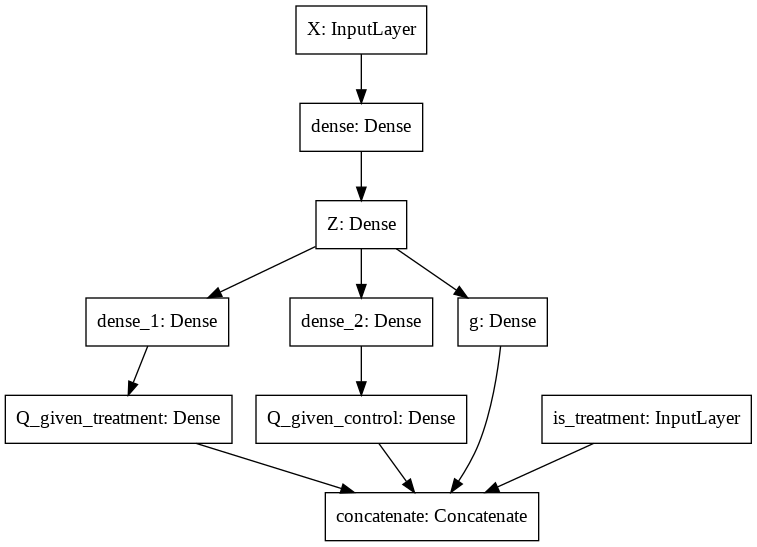

In [0]:
input_layer = k.layers.Input(shape=(x.shape[1],), name='X')
treatment_label_layer = k.layers.Input(shape=(1,), name='is_treatment')

# Compute Z
z = k.layers.Dense(75, activation='elu')(input_layer)
z = k.layers.Dense(25, activation='linear', name='Z')(z)

# Propensity estimator
g_hat = k.layers.Dense(1, activation='sigmoid', name='g')(z)

# Treatment Network
q_given_treatment = k.layers.Dense(25, activation='elu')(z)
q_given_treatment = k.layers.Dense(1, name='Q_given_treatment')(q_given_treatment)  # Set to the output dimensionality

# Control Network
q_given_control = k.layers.Dense(25, activation='elu')(z)
q_given_control = k.layers.Dense(1, name='Q_given_control')(q_given_control)

# Training output
concat_output = k.layers.concatenate([q_given_treatment, q_given_control, g_hat, treatment_label_layer])

treatment_model = k.models.Model(input_layer, q_given_treatment)
control_model = k.models.Model(input_layer, q_given_control)
propensity_model = k.models.Model(input_layer, g_hat)
trainable_model = k.models.Model([input_layer, treatment_label_layer], concat_output)

# Compile Models
print(trainable_model.summary())

k.utils.plot_model(trainable_model, to_file='tmp.png')
display(Image('tmp.png'))

trainable_model.compile(
    optimizer=k.optimizers.Adam(),
    loss=causal_regression_with_propensity_score,
    metrics=[conditional_average_treatment_effect, treatment_accuracy, propensity_xentropy]
)

In [0]:
hist = trainable_model.fit(
    [x, treatment_labels], y,
    epochs=10000, batch_size=len(x),
    validation_split=0.1,
    callbacks=[
        k.callbacks.EarlyStopping(monitor='val_loss', patience=50),
        k.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6, verbose=True),
        k.callbacks.TerminateOnNaN(),
        k.callbacks.ModelCheckpoint('tmp.chk', monitor='val_loss', save_best_only=True)
    ],
    verbose=True
)

W0826 03:12:33.945656 139795703113600 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 90000 samples, validate on 10000 samples
Epoch 1/10000
90000/90000 [==============================] - 1s 9us/sample - loss: 181.2877 - conditional_average_treatment_effect: 0.0918 - treatment_accuracy: 0.3313 - propensity_xentropy: 1.5545 - val_loss: 180.2046 - val_conditional_average_treatment_effect: 0.2123 - val_treatment_accuracy: 0.3322 - val_propensity_xentropy: 1.5426
Epoch 2/10000
90000/90000 [==============================] - 0s 3us/sample - loss: 178.6248 - conditional_average_treatment_effect: 0.1966 - treatment_accuracy: 0.3352 - propensity_xentropy: 1.5222 - val_loss: 177.6342 - val_conditional_average_treatment_effect: 0.3176 - val_treatment_accuracy: 0.3371 - val_propensity_xentropy: 1.5123
Epoch 3/10000
90000/90000 [==============================] - 0s 2us/sample - loss: 176.0477 - conditional_average_treatment_effect: 0.3018 - treatment_accuracy: 0.3395 - propensity_xentropy: 1.4920 - val_loss: 175.1199 - val_conditional_average_treatment_effect: 0.4223 - val_

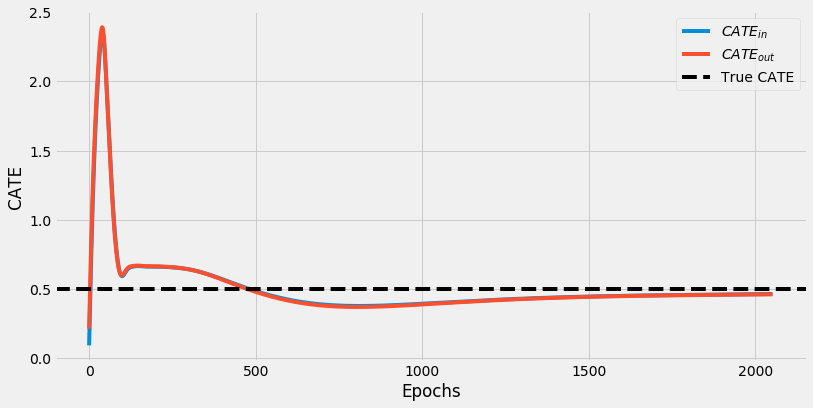

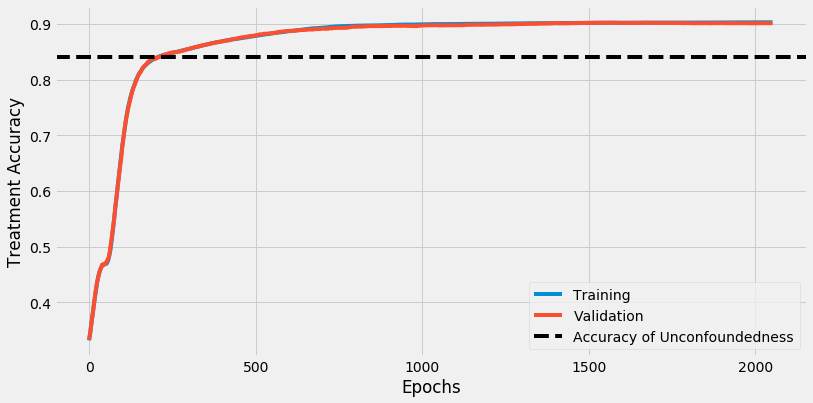

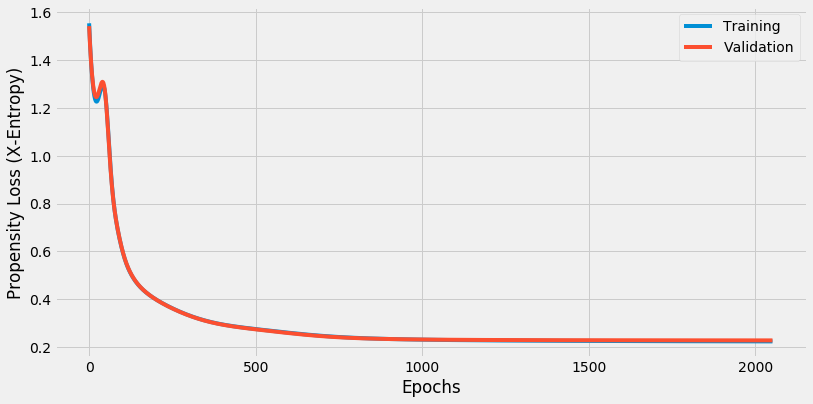

In [0]:
graph.figure(figsize=(12, 6))
graph.plot(hist.history['conditional_average_treatment_effect'], label=r'$CATE_{in}$')
graph.plot(hist.history['val_conditional_average_treatment_effect'], label=r'$CATE_{out}$')
graph.axhline(treatment_effect, linestyle='--', color='black', label='True CATE')
graph.ylabel('CATE')
graph.xlabel('Epochs')
graph.legend()
graph.show()

graph.figure(figsize=(12, 6))
graph.plot(hist.history['treatment_accuracy'], label='Training')
graph.plot(hist.history['val_treatment_accuracy'], label='Validation')
graph.axhline(
    max(treatment_labels.mean(), 1-treatment_labels.mean()), 
    linestyle='--', color='black', 
    label='Accuracy of Unconfoundedness'
)
graph.ylabel('Treatment Accuracy')
graph.xlabel('Epochs')
graph.legend()
graph.show()

graph.figure(figsize=(12, 6))
graph.plot(hist.history['propensity_xentropy'], label='Training')
graph.plot(hist.history['val_propensity_xentropy'], label='Validation')
graph.ylabel('Propensity Loss (X-Entropy)')
graph.xlabel('Epochs')
graph.legend()
graph.show()